In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip -q install -U transformers datasets accelerate evaluate
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.4 MB/s eta 0:00:00


In [3]:
path = "/content/drive/MyDrive/AI_Human.csv"
df = pd.read_csv(path)

print(df.shape)
print(df.columns)
print(df.head())


(487235, 2)
Index(['text', 'generated'], dtype='object')
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0


In [4]:
df = df[['text','generated']].copy()
df = df.dropna(subset=['text','generated'])
df['text'] = df['text'].astype(str)
df['generated'] = pd.to_numeric(df['generated'], errors='coerce')
df = df.dropna(subset=['generated'])
df['generated'] = df['generated'].astype(int)

df = df.drop_duplicates(subset=['text'])
df = df[df['text'].str.len() >= 20].reset_index(drop=True)

print(df.shape)
print(df['generated'].value_counts())


(487228, 2)
generated
0    305797
1    181431
Name: count, dtype: int64


In [5]:
n_total = 10000
n_each = n_total // 2

df0 = df[df['generated'] == 0].sample(n=n_each, random_state=42)
df1 = df[df['generated'] == 1].sample(n=n_each, random_state=42)

df10k = pd.concat([df0, df1]).sample(frac=1, random_state=42).reset_index(drop=True)   #shuffle

print(df10k.shape)
print(df10k['generated'].value_counts())


(10000, 2)
generated
1    5000
0    5000
Name: count, dtype: int64


In [6]:
train_df, temp_df = train_test_split(
    df10k,
    test_size=0.3,
    random_state=42,
    stratify=df10k['generated']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=2/3,
    random_state=42,
    stratify=temp_df['generated']
)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


(7000, 2)
(1000, 2)
(2000, 2)


In [7]:
train_hf = Dataset.from_pandas(train_df[['text','generated']].rename(columns={'generated':'labels'}), preserve_index=False)
val_hf = Dataset.from_pandas(val_df[['text','generated']].rename(columns={'generated':'labels'}), preserve_index=False)
test_hf = Dataset.from_pandas(test_df[['text','generated']].rename(columns={'generated':'labels'}), preserve_index=False)

train_hf, val_hf, test_hf


(Dataset({
     features: ['text', 'labels'],
     num_rows: 7000
 }),
 Dataset({
     features: ['text', 'labels'],
     num_rows: 1000
 }),
 Dataset({
     features: ['text', 'labels'],
     num_rows: 2000
 }))

In [8]:
model_name2 = "distilbert-base-uncased"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)

max_len = 128

def tok2(batch):
    return tokenizer2(batch["text"], truncation=True, padding="max_length", max_length=max_len)

train_tok2 = train_hf.map(tok2, batched=True)
val_tok2 = val_hf.map(tok2, batched=True)
test_tok2 = test_hf.map(tok2, batched=True)

cols = ["input_ids", "attention_mask", "labels"]
train_tok2 = train_tok2.remove_columns([c for c in train_tok2.column_names if c not in cols])
val_tok2 = val_tok2.remove_columns([c for c in val_tok2.column_names if c not in cols])
test_tok2 = test_tok2.remove_columns([c for c in test_tok2.column_names if c not in cols])

train_tok2.set_format("torch")
val_tok2.set_format("torch")
test_tok2.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}


In [10]:
model_name2 = "distilbert-base-uncased"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

model2 = AutoModelForSequenceClassification.from_pretrained(model_name2, num_labels=2)

args2 = TrainingArguments(
    output_dir="/content/distilbert_ai_detect",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none"
)

trainer2 = Trainer(
    model=model2,
    args=args2,
    train_dataset=train_tok2,
    eval_dataset=val_tok2,
    tokenizer=tokenizer2,
    compute_metrics=compute_metrics
)

trainer2.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3439860310.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


Step,Training Loss


TrainOutput(global_step=438, training_loss=0.14073546945232235, metrics={'train_runtime': 167.0092, 'train_samples_per_second': 83.828, 'train_steps_per_second': 2.623, 'total_flos': 463635895296000.0, 'train_loss': 0.14073546945232235, 'epoch': 2.0})

In [25]:
from sklearn.metrics import classification_report

test_out2 = trainer2.predict(test_tok2)

preds2 = np.argmax(test_out2.predictions, axis=1)
labels2 = test_out2.label_ids

acc = accuracy_score(labels2, preds2)
print("Accuracy:", acc)

print("\nClassification Report:\n")
print(classification_report(labels2, preds2, digits=2))



Accuracy: 0.9685

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1000
           1       0.95      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



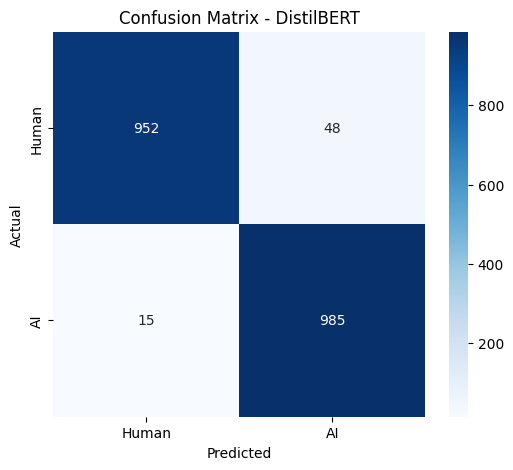

In [26]:
cm = confusion_matrix(labels2, preds2)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Human", "AI"],
    yticklabels=["Human", "AI"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT")
plt.show()


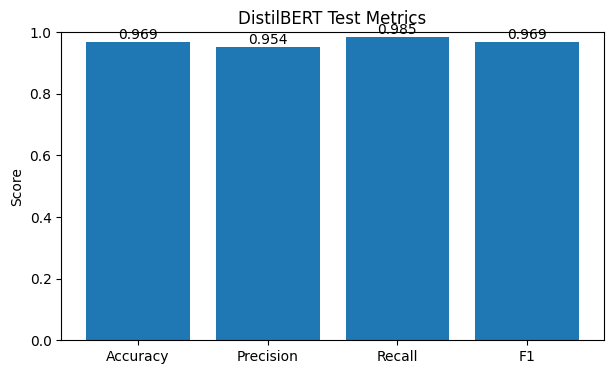

In [22]:
m2 = test_out2.metrics

names = ["Accuracy", "Precision", "Recall", "F1"]
values = [m2["test_accuracy"], m2["test_precision"], m2["test_recall"], m2["test_f1"]]

plt.figure(figsize=(7,4))
bars = plt.bar(names, values)
plt.ylim(0,1)

for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + 0.01, f"{y:.3f}", ha="center")

plt.title("DistilBERT Test Metrics")
plt.ylabel("Score")
plt.show()
